In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
from SNARS import Snars
from time import sleep
import re
import json

## P8.1
Prepare a code which draw for given network plot of the relation $C(k)$ [20%]

## P8.2
Find examples of hierarchical and non-hierarchical networks inavailable repositories, check by drawing graphs from the taskP8.1. [10%]

## P8.3
Load (perhaps a sub-) set of stops from the data provided byZTM Warszawa on the websitewww.ztm.waw.pl/pliki-do-pobrania/dane-rozkladowe/. Draw graphsbased on this set of vertices associated with the various typesof mass transport. [50%]

In [7]:
routes = json.load(open("routes_week.json", 'r'))
points = json.load(open("points.json", 'r'))
points = {k: (v['lon'], v['lat']) for k, v in points.items()}
edge_list=[]
for k,v in routes.items():
    for end in v.keys():
        edge_list+=[(k, end)]
G = nx.from_edgelist(edge_list)

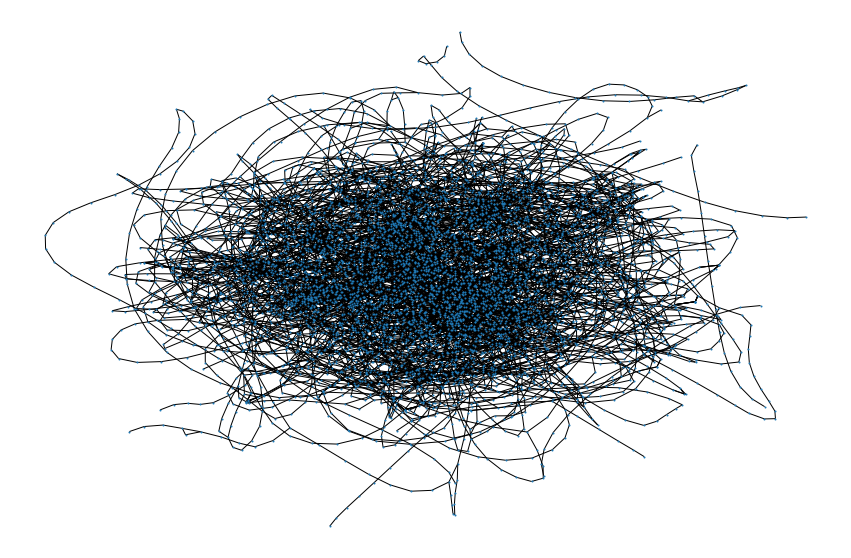

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw_spring(G, node_size =1, ax=ax )

## P8.4
Calculate the basic characteristics of each layer, and the wholenetwork. [20%]

## P8.5

Translate GPS coordinates to configuration of the vertices anddraw graph in proper, geographic, configuration. [30%]

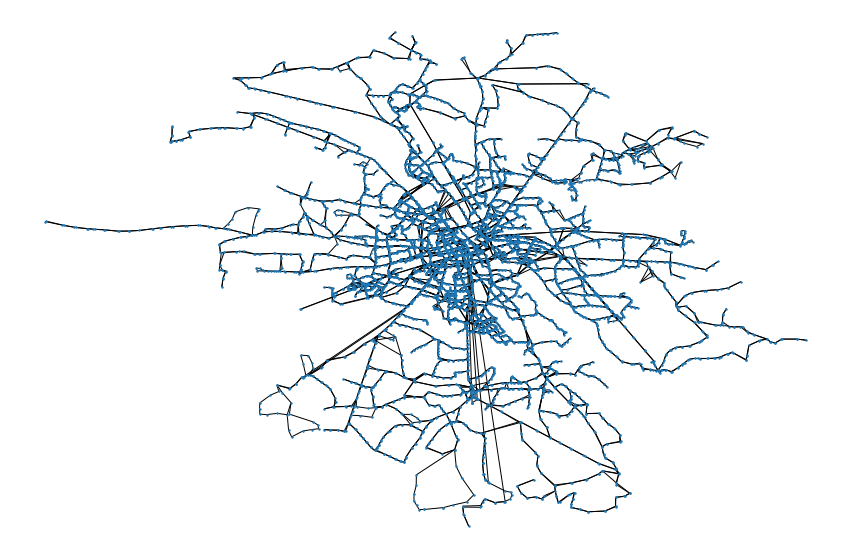

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(G, pos=points, node_size =2, ax=ax)

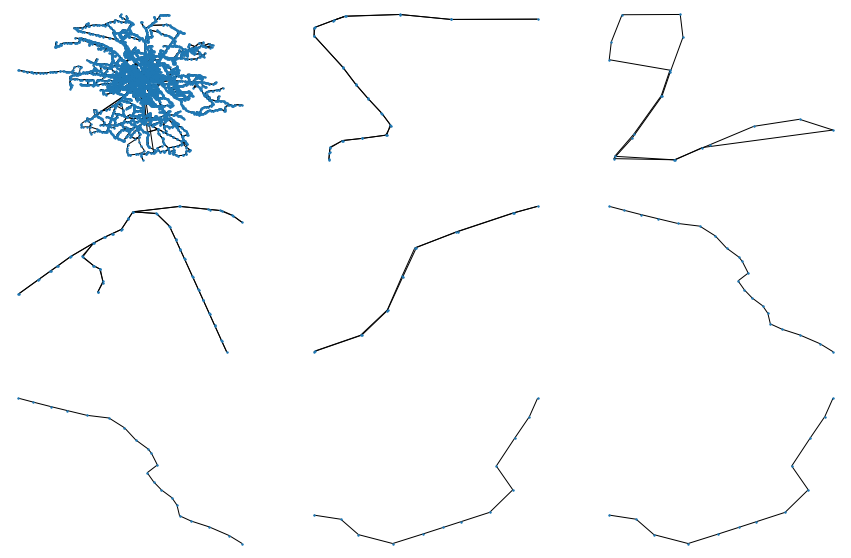

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(15,10))
for i, v in enumerate(nx.connected_components(G)):
    g = nx.subgraph(G, v)
    nx.draw(g, pos=points, node_size =2, ax=ax[i//3, i%3])

## P8.9
Working in groups, let’s ask ourselves a simple researchquestion about the ZTM network and try to answer it! [50%]